In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt



In [2]:
###############################################################################
# Figure configuration
import matplotlib as mpl
plt.rcParams['figure.figsize'] = (16, 6)

###############################################################################
# Load and Define dataset:
start_date = datetime(2020,1,1)
end_date = datetime(2023,12,31)
DATA_raw = pd.read_csv('INFOP7374_FeatureMart4GS.csv', index_col = [0])
DATA_raw.describe()

,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,RMW,...,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,USRECD,USRECDM,USRECDP,Yest_Close,stock_return
count,964.000000,964.000000,964.000000,964.000000,964.000000,9.640000e+02,964.000000,964.000000,964.000000,964.000000,...,687.000000,591.000000,451.000000,961.000000,958.000000,964.000000,964.000000,964.000000,964.000000,964.000000
mean,334.750114,339.503859,329.523195,334.638465,334.638465,1.577680e+06,0.035259,-0.004855,-0.000965,0.036214,...,1.691980,1.278934,1.946452,69.695182,3.777109,0.044606,0.042531,0.042531,334.472427,0.000903
std,55.983398,55.727324,55.719510,55.537704,55.537704,1.399268e+06,1.507510,0.820970,1.247044,0.693444,...,1.971611,1.798368,1.986418,22.996900,2.142485,0.206544,0.201902,0.201902,55.600831,0.026780
min,135.119995,140.639999,128.850006,138.979996,138.979996,3.974000e+05,-12.000000,-4.550000,-5.020000,-2.160000,...,0.040000,0.030000,0.040000,-36.980000,1.330000,0.000000,0.000000,0.000000,138.979996,-0.213692
25%,307.182503,312.150009,302.125000,307.575005,307.575005,9.458750e+05,-0.682500,-0.500000,-0.720000,-0.420000,...,0.130000,0.080000,0.100000,52.610000,2.230000,0.000000,0.000000,0.000000,307.464996,-0.012554
50%,331.455002,336.884995,326.729996,331.585007,331.585007,1.281050e+06,0.060000,-0.010000,-0.050000,0.015000,...,0.420000,0.150000,1.290000,72.530000,2.865000,0.000000,0.000000,0.000000,331.559998,0.000894
75%,375.274994,379.189995,370.575005,375.680008,375.680008,1.754400e+06,0.800000,0.452500,0.720000,0.492500,...,3.365000,1.605000,3.910000,84.050000,4.887500,0.000000,0.000000,0.000000,375.482513,0.014734
max,476.779999,485.829987,469.089996,477.910004,477.910004,2.806470e+07,9.340000,5.700000,6.730000,4.200000,...,5.540000,5.410000,5.430000,123.640000,23.860000,1.000000,1.000000,1.000000,477.910004,0.127158


In [3]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,12,31)
DATA_raw['Date'] = pd.to_datetime(DATA_raw['Date'])
mask = (DATA_raw['Date'] >= start_date) & (DATA_raw['Date'] <= end_date)
DATA_raw = DATA_raw.loc[mask]
DATA_raw.reset_index(drop = True, inplace = True)
DATA_raw

,Date,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,...,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,USRECD,USRECDM,USRECDP,Yest_Close,stock_return
0,2020-01-03,231.240005,234.500000,230.229996,232.639999,232.639999,1315400,-0.67,0.30,0.00,...,1.70,1.60,1.55,63.00,2.06,0.0,0.0,0.0,233.419998,-0.003342
1,2020-01-06,231.490005,235.529999,230.800003,235.429993,235.429993,1460700,0.36,-0.20,-0.55,...,1.68,1.60,1.55,63.27,2.10,0.0,0.0,0.0,232.639999,0.011993
2,2020-01-07,235.500000,236.850006,233.339996,233.699997,233.699997,1367900,-0.19,-0.03,-0.25,...,1.66,1.62,1.56,62.70,2.17,0.0,0.0,0.0,235.429993,-0.007348
3,2020-01-08,234.880005,238.009995,234.009995,237.270004,237.270004,1883900,0.47,-0.17,-0.64,...,1.64,1.61,1.53,59.65,2.09,0.0,0.0,0.0,233.699997,0.015276
4,2020-01-09,239.220001,239.470001,235.289993,235.899994,235.899994,1141300,0.65,-0.71,-0.48,...,1.70,1.61,NaN,59.56,2.05,0.0,0.0,0.0,237.270004,-0.005774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,2023-10-25,401.000000,403.820007,396.119995,396.700012,396.700012,1309700,-1.58,-0.02,0.84,...,5.50,5.37,NaN,86.07,2.86,0.0,0.0,0.0,403.369995,-0.016536
960,2023-10-26,393.179993,394.040009,386.000000,388.619995,388.619995,1837200,-1.15,1.19,1.66,...,NaN,5.40,NaN,83.80,2.87,0.0,0.0,0.0,396.700012,-0.020368
961,2023-10-27,390.000000,392.209991,384.369995,386.820007,386.820007,1448600,-0.53,-0.58,-0.57,...,5.49,5.36,5.36,86.04,3.24,0.0,0.0,0.0,388.619995,-0.004632
962,2023-10-30,388.440002,393.269989,387.750000,391.750000,391.750000,1005200,1.15,-0.34,0.28,...,NaN,NaN,5.40,83.03,3.17,0.0,0.0,0.0,386.820007,0.012745


In [4]:
# copy the data
DATA = DATA_raw.copy() 
exclude_columns = ['Adj Close', 'Yest_Close', 'stock_return']
# NORMALIZATION
for column in DATA_raw.columns[1:]:
    if column not in exclude_columns:
        DATA[column] = (DATA_raw[column] -
                               DATA_raw[column].mean()) / DATA_raw[column].std()  

In [5]:
DATA

,Date,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,...,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,USRECD,USRECDM,USRECDP,Yest_Close,stock_return
0,2020-01-03,-1.848943,-1.884244,-1.782019,-1.836563,232.639999,-0.187441,-0.467831,0.371335,0.000774,...,0.004068,0.178532,-0.199581,-0.291134,-0.801457,-0.215963,-0.210652,-0.210652,233.419998,-0.003342
1,2020-01-06,-1.844477,-1.865761,-1.771789,-1.786326,235.429993,-0.083601,0.215415,-0.237701,-0.440269,...,-0.006076,0.178532,-0.199581,-0.279393,-0.782787,-0.215963,-0.210652,-0.210652,232.639999,0.011993
2,2020-01-07,-1.772849,-1.842074,-1.726203,-1.817476,233.699997,-0.149921,-0.149425,-0.030629,-0.199701,...,-0.016220,0.189653,-0.194547,-0.304179,-0.750114,-0.215963,-0.210652,-0.210652,235.429993,-0.007348
3,2020-01-08,-1.783924,-1.821259,-1.714179,-1.753196,237.270004,0.218843,0.288383,-0.201159,-0.512440,...,-0.026364,0.184092,-0.209650,-0.436806,-0.787454,-0.215963,-0.210652,-0.210652,233.699997,0.015276
4,2020-01-09,-1.706401,-1.795059,-1.691207,-1.777864,235.899994,-0.311863,0.407785,-0.858917,-0.384137,...,0.004068,0.184092,NaN,-0.440719,-0.806124,-0.215963,-0.210652,-0.210652,237.270004,-0.005774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,2023-10-25,1.183385,1.154122,1.195215,1.117467,396.700012,-0.191514,-1.071475,-0.018448,0.674367,...,1.931425,2.274877,NaN,0.712045,-0.428058,-0.215963,-0.210652,-0.210652,403.369995,-0.016536
960,2023-10-26,1.043700,0.978625,1.013591,0.971980,388.619995,0.185469,-0.786237,1.455418,1.331922,...,NaN,2.291559,NaN,0.613336,-0.423391,-0.215963,-0.210652,-0.210652,396.700012,-0.020368
961,2023-10-27,0.986898,0.945786,0.984337,0.939570,386.820007,-0.092248,-0.374962,-0.700568,-0.456307,...,1.926353,2.269317,1.718444,0.710740,-0.250694,-0.215963,-0.210652,-0.210652,388.619995,-0.004632
962,2023-10-30,0.959032,0.964807,1.044999,1.028338,391.750000,-0.409128,0.739458,-0.408231,0.225305,...,NaN,NaN,1.738580,0.579853,-0.283367,-0.215963,-0.210652,-0.210652,386.820007,0.012745


In [6]:
DATA.columns
columns_to_drop = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Yest_Close','stock_return']

# Drop the specified columns
X = DATA.drop(columns = columns_to_drop).fillna(method='bfill')
# X = X.fillna(method='bfill')

y = DATA['Adj Close']

# Data Issues:
# missing_values = X.isnull().sum()
# X['DCPF1M'].fillna(method='ffill', inplace=True)

In [7]:
DATA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,...,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,USRECD,USRECDM,USRECDP,Yest_Close,stock_return
0,2020-01-03,-1.848943,-1.884244,-1.782019,-1.836563,232.639999,-0.187441,-0.467831,0.371335,0.000774,...,0.004068,0.178532,-0.199581,-0.291134,-0.801457,-0.215963,-0.210652,-0.210652,233.419998,-0.003342
1,2020-01-06,-1.844477,-1.865761,-1.771789,-1.786326,235.429993,-0.083601,0.215415,-0.237701,-0.440269,...,-0.006076,0.178532,-0.199581,-0.279393,-0.782787,-0.215963,-0.210652,-0.210652,232.639999,0.011993
2,2020-01-07,-1.772849,-1.842074,-1.726203,-1.817476,233.699997,-0.149921,-0.149425,-0.030629,-0.199701,...,-0.016220,0.189653,-0.194547,-0.304179,-0.750114,-0.215963,-0.210652,-0.210652,235.429993,-0.007348
3,2020-01-08,-1.783924,-1.821259,-1.714179,-1.753196,237.270004,0.218843,0.288383,-0.201159,-0.512440,...,-0.026364,0.184092,-0.209650,-0.436806,-0.787454,-0.215963,-0.210652,-0.210652,233.699997,0.015276
4,2020-01-09,-1.706401,-1.795059,-1.691207,-1.777864,235.899994,-0.311863,0.407785,-0.858917,-0.384137,...,0.004068,0.184092,NaN,-0.440719,-0.806124,-0.215963,-0.210652,-0.210652,237.270004,-0.005774


In [8]:
print(X.shape)
print(y.shape)

(964, 24)
(964,)


In [9]:
X.head()

,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,SP500,AMERIBOR,...,DGS10,DGS1,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,USRECD,USRECDM,USRECDP
0,-0.187441,-0.467831,0.371335,0.000774,-0.254114,-0.181559,0.007054,0.000412,-1.363160,-0.059495,...,-0.336834,-0.191238,0.004068,0.178532,-0.199581,-0.291134,-0.801457,-0.215963,-0.210652,-0.210652
1,-0.083601,0.215415,-0.237701,-0.440269,-0.297376,-0.445494,0.007054,0.010582,-1.341125,-0.059282,...,-0.328899,-0.195978,-0.006076,0.178532,-0.199581,-0.279393,-0.782787,-0.215963,-0.210652,-0.210652
2,-0.149921,-0.149425,-0.030629,-0.199701,-0.225272,-0.428998,0.007054,0.013761,-1.358668,-0.060345,...,-0.313030,-0.200719,-0.016220,0.189653,-0.194547,-0.304179,-0.750114,-0.215963,-0.210652,-0.210652
3,0.218843,0.288383,-0.201159,-0.512440,-0.326218,-0.297030,0.007054,0.016834,-1.328074,-0.065608,...,-0.281290,-0.191238,-0.026364,0.184092,-0.209650,-0.436806,-0.787454,-0.215963,-0.210652,-0.210652
4,-0.311863,0.407785,-0.858917,-0.384137,-0.254114,0.049385,0.007054,0.019802,-1.286338,-0.064661,...,-0.297160,-0.195978,0.004068,0.184092,-0.184479,-0.440719,-0.806124,-0.215963,-0.210652,-0.210652


In [10]:
# define the model
min_cols = 3
model = xgb.XGBRegressor(objective ='reg:linear',  
                         n_estimators=20,
                          learning_rate = 0.1,
                          max_depth = min_cols, 
                          alpha = 10, 
                          eta=0.1,
                          subsample = 0.7,
                          colsample_bytree=0.8,
                          reg_lambda=1,
                          gamma=0)
# fit the model
model.fit(X, y)

[19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, ...)

In [11]:
df_feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, \
                                     columns=['feature_importance']).sort_values('feature_importance', ascending=False)
print(df_feature_importance)
print(df_feature_importance.count())

                feature_importance
SP500                     0.247420
ADS_Index                 0.183434
AMERIBOR                  0.106154
DHHNGSP                   0.077964
BAMLH0A0HYM2              0.074938
DCPN3M                    0.052642
DCPF1M                    0.051796
USRECDP                   0.042269
DCOILWTICO                0.037140
DGS1                      0.028734
T5YIE                     0.027956
DGS10                     0.024822
BAMLH0A0HYM2EY            0.024101
USRECDM                   0.013631
T10YIE                    0.006925
CMA                       0.000072
RF                        0.000000
Mkt-RF                    0.000000
RIFSPPFAAD90NB            0.000000
RMW                       0.000000
HML                       0.000000
SMB                       0.000000
USRECD                    0.000000
Volume                    0.000000
feature_importance    24
dtype: int64


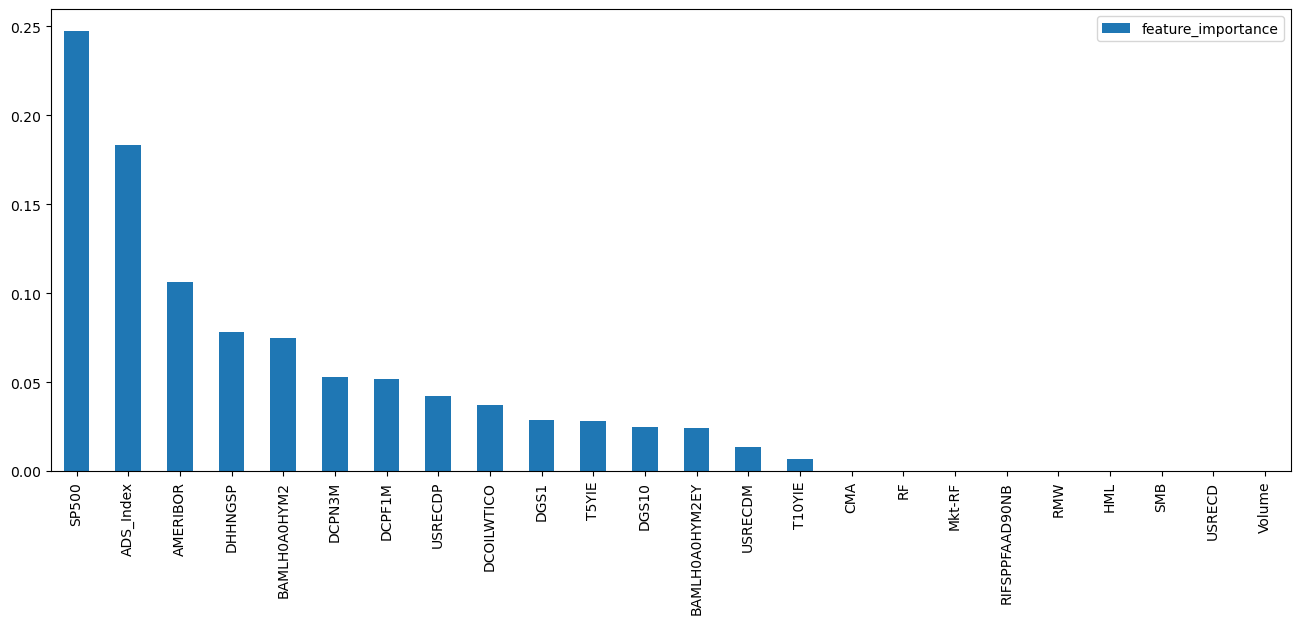

In [12]:
# 2. visualize feature importance (run each line sequentially)
# (1) bar chart
df_feature_importance.plot(kind='bar');

In [13]:
#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [3, 5, 10],
              "n_estimators": [10, 50, 100],
              "learning_rate": [0.15, 0.3]}

# try out every combination of the above values
regressor = xgb.XGBRegressor(eval_metric='rmse')
search = GridSearchCV(regressor, param_grid, cv=5).fit(X, y)

print("The best hyperparameters are ",search.best_params_)
regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X, y)

The best hyperparameters are  {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 100}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

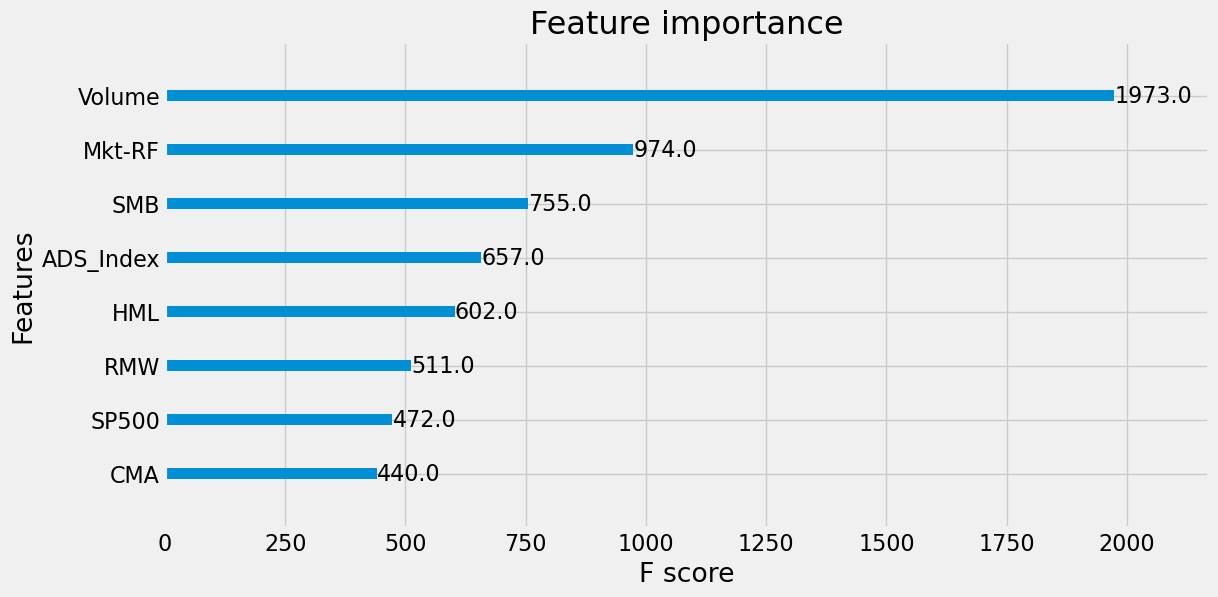

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

In [15]:
#=========================================================================
# To use early_stopping_rounds: 
# "Validation metric needs to improve at least once in every 
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split 
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
y_hat = regressor.predict(X_test)

/Users/hrishikeshwarrier/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [16]:
###############################################################################
# Cross Validation:
# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Let's get the mean score
mean_cv_score = np.mean(cv_scores)

# Get feature importances
feature_importances = model.feature_importances_

# Print the results
print("Mean Cross-Validation Score:", mean_cv_score)
print("Feature Importances:", feature_importances)

# Evaluate Model:
# Calculate the mean squared error and convert it back to positive
mse_scores = -cv_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

rmse = np.mean(np.sqrt(np.abs(cv_scores)))
std_rmse = np.std(np.sqrt(np.abs(cv_scores)))
print('---------------------------------------','\n')
print(f'MEAN of Mean Squared Error: {mean_mse}')
print('---------------------------------------','\n')
print(f'STD of RMSE Squared Error: {std_rmse}')
print('---------------------------------------','\n')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('---------------------------------------','\n')

Mean Cross-Validation Score: -2545.8887534204187
Feature Importances: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2236515e-05 0.0000000e+00 1.8343425e-01 2.4742030e-01 1.0615416e-01
 6.9248397e-03 2.7955597e-02 7.4937612e-02 2.4101311e-02 2.4822479e-02
 2.8734248e-02 0.0000000e+00 5.2642271e-02 5.1796220e-02 3.7140477e-02
 7.7963851e-02 0.0000000e+00 1.3631435e-02 4.2268679e-02]
--------------------------------------- 

MEAN of Mean Squared Error: 2545.8887534204187
--------------------------------------- 

STD of RMSE Squared Error: 16.281738717525492
--------------------------------------- 

Root Mean Squared Error on Test Set: 47.75765632602431
--------------------------------------- 



In [17]:
## There is no overfitting given the STD of RMSE is smaller than RMSE

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_hat)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(rmse)

10.939085510455183
